In [ ]:
# installing tensorflow_text
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.6 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# load data
df = pd.read_csv('ham-spam-phishing.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I dont think he goes to usf, he lives arou..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
5756,phishing,2 new message
5757,phishing,your bill is here
5758,phishing,please check your
5759,phishing,"email has been reposted , regulation"


In [ ]:
# check count and unique and top values and their frequency
df['Category'].value_counts()

ham         4825
spam         747
phishing     189
Name: Category, dtype: int64

Clearly dataset is imbalanced - not so much but still it can affect our model. Need to use some type of regulariztion like downsampling dataset for mazority class

In [ ]:
# check percentange of data - states how much data needs to be balanced
str(round(189/747,2))+'%'

'0.25%'

In [ ]:
# creating 2 new dataframe as df_ham , df_phishing

df_phishing = df[df['Category']=='phishing']
print("Phishing Dataset Shape:", df_phishing.shape)

df_spam = df[df['Category']=='spam']
print("Spam Dataset Shape:", df_spam.shape)

Phishing Dataset Shape: (189, 2)
Spam Dataset Shape: (747, 2)


In [ ]:
# downsampling ham dataset - take only random 189 example
# will use df_spam.shape[0] - 199

df_spam_downsampled = df_spam.sample(df_phishing.shape[0])
df_spam_downsampled.shape

(189, 2)

In [ ]:
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_phishing , df_spam_downsampled])
df_balanced.head()

,Category,Message
5572,phishing,Are you available ?\nNo calls text only 951307...
5573,phishing,Im in a meeting and need help getting some Ama...
5574,phishing,Hello RECIPIENT\n\nI am urgently seeking for a...
5575,phishing,Are you around? I need to pay a vendor with th...
5576,phishing,Im in a meeting and need help getting some Ama...


In [ ]:
df_balanced['Category'].value_counts()

phishing    189
spam        189
Name: Category, dtype: int64

In [ ]:
df_balanced.sample(10)

,Category,Message
5698,phishing,message
5450,spam,Todays Voda numbers ending with 7634 are selec...
4926,spam,4mths half price Orange line rental & latest c...
5752,phishing,file
5699,phishing,pdf file
5172,spam,"Text82228>> Get more ringtones, logos and game..."
5202,spam,Married local women looking for discreet actio...
5719,phishing,see attached below
5632,phishing,notification message from faculty admin
5638,phishing,money for cancer diagnosied


Data Prepration


In [ ]:
# creating numerical repersentation of category - one hot encoding
df_balanced['phishing'] = df_balanced['Category'].apply(lambda x:1 if x=='phishing' else 0)

In [ ]:
# displaying data - phishing -1 , spam-0
df_balanced.sample(4)

,Category,Message,phishing
5738,phishing,email account recently signed,1
5691,phishing,"office365 is ready. Payment, credit card",1
5760,phishing,request to deactivate,1
5556,spam,Txt: CALL to No: 86888 & claim your reward of ...,0


Do train-test split
split dataset into 80-20 ratio with 80% train and remaing as test
for eveness of data we will use stratify agrument which ensures same ratio of both category is loaded for each case, even if one categoy has more training samples - prevents overfitting

In [ ]:
# loading train test split
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message '], df_balanced['phishing'],
                                                    stratify = df_balanced['phishing'])

In [ ]:
# check for startification
y_train.value_counts()

1    142
0    141
Name: phishing, dtype: int64

In [ ]:
142/141

1.0070921985815602

In [ ]:
y_test.value_counts()

0    48
1    47
Name: phishing, dtype: int64

In [ ]:
48/47

1.0212765957446808

In [ ]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
import tensorflow as tf

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
# check summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Compiling model
Optimizer - ADAM
Loss - binary_crossentropy
metrics - accuracy , precesion and recall

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [ ]:
import tensorflow as tf
import datetime
%load_ext tensorboard

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(X_train, y_train, epochs = 5 , callbacks = [tensorboard_callback])

Epoch 1/5
9/9 [==============================] - 190s 20s/step - loss: 0.7887 - accuracy: 0.3781 - precision: 0.3333 - recall: 0.2394
Epoch 2/5
9/9 [==============================] - 165s 19s/step - loss: 0.6771 - accuracy: 0.5689 - precision: 0.5588 - recall: 0.6690
Epoch 3/5
9/9 [==============================] - 168s 19s/step - loss: 0.6023 - accuracy: 0.7350 - precision: 0.7638 - recall: 0.6831
Epoch 4/5
9/9 [==============================] - 177s 20s/step - loss: 0.5548 - accuracy: 0.7703 - precision: 0.8291 - recall: 0.6831
Epoch 5/5
9/9 [==============================] - 175s 20s/step - loss: 0.5248 - accuracy: 0.7951 - precision: 0.8231 - recall: 0.7535


In [ ]:
# Evaluating performace
model.evaluate(X_test,y_test)

3/3 [==============================] - 69s 20s/step - loss: 0.4903 - accuracy: 0.8421 - precision: 0.8636 - recall: 0.8085


[0.4902821481227875,
 0.8421052694320679,
 0.8636363744735718,
 0.8085106611251831]

In [ ]:
# getting y_pred by predicting over X_text and flattening it
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one dimensional array , for easy maniputation


3/3 [==============================] - 48s 16s/step


In [ ]:
# checking the results y_pred
import numpy as np

y_pred = np.where(y_pred>0.5,1,0 )
y_pred

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0])

In [ ]:
# importing consfusion maxtrix
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
# creating confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[42,  6],
       [ 9, 38]])

In [ ]:
# plotting as graph - importing seaborn
import seaborn as sns

Text(50.722222222222214, 0.5, 'Actual')

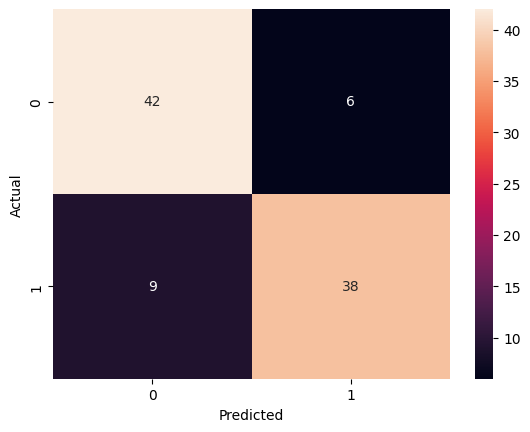

In [ ]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# printing classification report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        48
           1       0.86      0.81      0.84        47

    accuracy                           0.84        95
   macro avg       0.84      0.84      0.84        95
weighted avg       0.84      0.84      0.84        95



Good Precision And Recall Score, but can be improved

Model Prediction
We will be predicting data on text coprus, value > 5 is most likely be phishing

In [ ]:
predict_text = [
                # Phishing
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund',
                'Your account is temporarily frozen. Please log in to to secure your account ',

                #spam
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [ ]:
test_results = model.predict(predict_text)

1/1 [==============================] - 3s 3s/step


In [ ]:
output = np.where(test_results>0.5,'phising', 'spam')

In [ ]:
output

array([['phising'],
       ['spam'],
       ['spam'],
       ['phising'],
       ['spam'],
       ['spam']], dtype='<U7')

Create a function which will take in sentece array and return the embedding vector for entire sentece -pooled_output

In [ ]:
def get_embedding(sentence_arr):
    'takes in sentence array and return embedding vector'
    preprocessed_text = bert_preprocessor(sentence_arr)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

In [ ]:
e = get_embedding([
               'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
               'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
])

In [ ]:
# load similartiy score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# check similarity score
print(f'Similarity score between 1st sentence(phishing) and second sentence(phishing) : {cosine_similarity([e[0]] , [e[1]])}')

Similarity score between 1st sentence(phishing) and second sentence(phishing) : [[0.85391915]]
